In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

# Importing & Preparing Data

In [2]:
twitter_df = pd.read_csv('edgelist.csv')
hateful_user_df = pd.read_csv('hateful_users.csv')

# Filter out rows where src and dst are the same
filtered_twitter_df = twitter_df[twitter_df['src'] != twitter_df['dst']]

# Identify the excluded user IDs in twitter_df
excluded_ids = set(twitter_df['src']) - set(filtered_twitter_df['src'])
excluded_ids.update(set(twitter_df['dst']) - set(filtered_twitter_df['dst']))

# Filter out these user IDs from hateful_user_df
filtered_hateful_user_df = hateful_user_df[~hateful_user_df['user_id'].isin(excluded_ids)]

In [3]:
hateful_user_df.head(3)

,user_id,producer,consumer,outdegree,indegree,degree,outstrength,instrength,strength,n_tweets,n_hate_tweets,n_northerner_tweets,n_hausa_tweets,n_fulani_tweets,n_southerner_tweets,n_yoruba_tweets,n_biafra_tweets,n_igbo_tweets,n_retweets,n_hate_retweets,n_northerner_retweets,n_hausa_retweets,n_fulani_retweets,n_southerner_retweets,n_yoruba_retweets,n_biafra_retweets,n_igbo_retweets,n_likes,n_hate_likes,n_northerner_likes,n_hausa_likes,n_fulani_likes,n_southerner_likes,n_yoruba_likes,n_biafra_likes,n_igbo_likes,ethnicity,religion,gender,user_timestamp,user_followers_count,user_friends_count,user_statuses_count,user_favourites_count,user_verified,sampling_proportion_likes,sampling_proportion_timelines
0,11172,1.0,1.0,7,11,16,11.0,98.0,109.0,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1016,10,10,0,0,0,0,0,0,NaN,NaN,NaN,1.162282e+09,259.0,334.0,2544.0,32294.0,False,0.029260,0.998249
1,2340131,1.0,1.0,1141,5,1008,1541.0,5.0,1546.0,106,3,1,0,2,0,0,0,0,78,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,igbo,christian,m,1.174936e+09,5301.0,665.0,1274.0,162.0,False,0.984909,0.998249
2,3741461,1.0,1.0,2,2,2,13.0,3.0,16.0,100,0,0,0,0,0,0,0,0,812,0,0,0,0,0,0,0,0,3139,2,2,0,0,0,0,0,0,NaN,NaN,NaN,1.175985e+09,637.0,742.0,5782.0,11655.0,False,0.951123,0.998249


In [4]:
twitter_df.head(3)

,dst,src,n_mentions,n_retweets,n_tweets
0,1642207375,1304915551467208707,4.0,4.0,4.0
1,703569617,985075589995524096,2.0,0.0,2.0
2,1675610269,1675610269,70.0,0.0,70.0


### Utility Functions

In [5]:
def draw_graph_spring(G, cat_df, attribute_name):
    # Get the values of the category
    cat_values = cat_df[cat_df.index.isin(G.nodes)][attribute_name].unique()
    colors = [plt.cm.Set2(i/float(len(cat_values)-1)) for i in range(len(cat_values))]

    # Create a dictionary mapping category values to colors & map nodes to colors
    value_to_color = dict(zip(cat_values, colors))
    node_colors = [value_to_color[cat_df.loc[n][attribute_name]] for n in G.nodes()]

    # Calculate the layout positions using the spring layout
    positions = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(15, 15))
    nx.draw(G, pos=positions, node_size=25, node_color=node_colors)

    # Create a patch for each category value
    patches = [plt.plot([],[], marker="o", color=colors[i], 
               label="{}".format(cat_values[i]))[0] for i in range(len(cat_values))]

    # Add legend
    plt.legend(handles=patches)

In [6]:
def get_connected_subset_by_ethnicity(G, num_nodes):
    # Ensure at least 5% nodes for each ethnicity
    min_nodes_per_ethnicity = int(num_nodes * 0.05)

    # Filter nodes by ethnicity
    nodes_igbo = [node for node, attr in G.nodes(data=True) if attr.get('ethnicity') == 'igbo']
    nodes_yoruba = [node for node, attr in G.nodes(data=True) if attr.get('ethnicity') == 'yoruba']
    nodes_hausa = [node for node, attr in G.nodes(data=True) if attr.get('ethnicity') == 'hausa']

    # Calculate the number of nodes for each ethnicity
    num_igbo = max(min_nodes_per_ethnicity, len(nodes_igbo))
    num_yoruba = max(min_nodes_per_ethnicity, len(nodes_yoruba))
    num_hausa = max(min_nodes_per_ethnicity, len(nodes_hausa))

    # Adjust the numbers if the total exceeds num_nodes
    total_num = num_igbo + num_yoruba + num_hausa
    while total_num > num_nodes:
        # Reduce the count of the largest group
        if num_igbo > num_yoruba and num_igbo > num_hausa:
            num_igbo -= 1
        elif num_yoruba > num_igbo and num_yoruba > num_hausa:
            num_yoruba -= 1
        else:
            num_hausa -= 1
        total_num = num_igbo + num_yoruba + num_hausa

    # Get connected components for each ethnicity
    components_igbo = [G.subgraph(c).copy() for c in nx.connected_components(G.subgraph(nodes_igbo))]
    components_yoruba = [G.subgraph(c).copy() for c in nx.connected_components(G.subgraph(nodes_yoruba))]
    components_hausa = [G.subgraph(c).copy() for c in nx.connected_components(G.subgraph(nodes_hausa))]

    # Sort connected components by size
    components_igbo.sort(key=len, reverse=True)
    components_yoruba.sort(key=len, reverse=True)
    components_hausa.sort(key=len, reverse=True)

    # Select the largest connected components for each ethnicity
    largest_cc_igbo = components_igbo[0] if components_igbo else None
    largest_cc_yoruba = components_yoruba[0] if components_yoruba else None
    largest_cc_hausa = components_hausa[0] if components_hausa else None

    # Select top nodes by degree within each ethnicity
    selected_nodes_igbo = sorted(largest_cc_igbo.nodes, key=lambda node: G.degree(node), reverse=True)[:num_igbo] if largest_cc_igbo else []
    selected_nodes_yoruba = sorted(largest_cc_yoruba.nodes, key=lambda node: G.degree(node), reverse=True)[:num_yoruba] if largest_cc_yoruba else []
    selected_nodes_hausa = sorted(largest_cc_hausa.nodes, key=lambda node: G.degree(node), reverse=True)[:num_hausa] if largest_cc_hausa else []

    # Create a subgraph with the selected nodes
    selected_nodes = selected_nodes_igbo + selected_nodes_yoruba + selected_nodes_hausa
    subset_graph = G.subgraph(selected_nodes)
    largest_cc = max(nx.connected_components(subset_graph), key=len, default=set())
    subset_graph = subset_graph.subgraph(largest_cc).copy()

    return subset_graph

In [7]:
def get_connected_subset_by_tweet_category(G, num_nodes):
    # Minimum representation for each category
    min_rep = int(num_nodes * 0.1)

    # Filter nodes by tweet category
    category_nodes = defaultdict(list)
    for node, data in G.nodes(data=True):
        category = data.get('tweet_category')
        category_nodes[category].append(node)

    # Ensure at least 10% nodes for each category
    for category in category_nodes:
        category_nodes[category] = random.sample(category_nodes[category], 
                                                 max(min_rep, len(category_nodes[category])))

    # Start from a random node
    start_node = random.choice(list(G.nodes()))
    visited = set([start_node])
    queue = [start_node]

    # Use tqdm for progress tracking
    with tqdm(total=num_nodes, desc="Building Subset") as pbar:
        while len(visited) < num_nodes and queue:
            current = queue.pop(0)
            neighbors = [n for n in G.neighbors(current) if n not in visited]

            # Randomize neighbors to add stochasticity
            random.shuffle(neighbors)

            for neighbor in neighbors:
                # Add neighbor if it maintains the 10% representation
                neighbor_category = G.nodes[neighbor].get('tweet_category')
                if len([n for n in visited if G.nodes[n].get('tweet_category') == neighbor_category]) < min_rep or \
                   len(visited) + len(queue) < num_nodes:
                    visited.add(neighbor)
                    queue.append(neighbor)
                    pbar.update(1)

                if len(visited) >= num_nodes:
                    break

    # Create the subgraph
    subset_graph = G.subgraph(visited).copy()

    return subset_graph

In [8]:
def get_connected_subset_by_hate_tweet_ethnicity(G, num_nodes):
    # Minimum representation for each category
    min_rep = int(num_nodes * 0.05)

    # Filter nodes by hate tweet category
    category_nodes = defaultdict(list)
    for node, data in G.nodes(data=True):
        category = data.get('ethnicity')
        category_nodes[category].append(node)

    # Start from a random node
    start_node = random.choice(list(G.nodes()))
    visited = set([start_node])
    queue = [start_node]

    # Use tqdm for progress tracking
    with tqdm(total=num_nodes, desc="Building Subset") as pbar:
        while len(visited) < num_nodes and queue:
            current = queue.pop(0)
            neighbors = [n for n in G.neighbors(current) if n not in visited]

            # Randomize neighbors to add stochasticity
            random.shuffle(neighbors)

            for neighbor in neighbors:
                # Add neighbor if it maintains the 5% representation
                neighbor_category = G.nodes[neighbor].get('ethnicity')
                if len([n for n in visited if G.nodes[n].get('ethnicity') == neighbor_category]) < min_rep or \
                   len(visited) + len(queue) < num_nodes:
                    visited.add(neighbor)
                    queue.append(neighbor)
                    pbar.update(1)

                if len(visited) >= num_nodes:
                    break

    # Create the subgraph
    subset_graph = G.subgraph(visited).copy()

    return subset_graph

In [9]:
def get_connected_subset_by_retweet(G, num_nodes):
    # Minimum representation for each retweet category
    min_rep = int(num_nodes * 0.05)

    # Filter nodes by retweet category
    retweet_categories = set(node_data.get('retweet_category') for node_data in G.nodes.values())
    category_nodes = defaultdict(list)
    for node, data in G.nodes(data=True):
        category = data.get('retweet_category')
        if category in retweet_categories:
            category_nodes[category].append(node)

    # Ensure at least 5% nodes for each category
    for category in category_nodes:
        min_category_nodes = min(min_rep, len(category_nodes[category]))
        category_nodes[category] = random.sample(category_nodes[category], min_category_nodes)

    # Start from a random node
    start_node = random.choice(list(G.nodes()))
    visited = set([start_node])
    queue = [start_node]

    # Use tqdm for progress tracking
    with tqdm(total=num_nodes, desc="Building Subset") as pbar:
        while len(visited) < num_nodes and queue:
            current = queue.pop(0)
            neighbors = [n for n in G.neighbors(current) if n not in visited]

            # Randomize neighbors to add stochasticity
            random.shuffle(neighbors)

            for neighbor in neighbors:
                # Add neighbor if it maintains the 5% representation
                neighbor_category = G.nodes[neighbor].get('retweet_category')
                if len([n for n in visited if G.nodes[n].get('retweet_category') == neighbor_category]) < min_rep or \
                   len(visited) + len(queue) < num_nodes:
                    visited.add(neighbor)
                    queue.append(neighbor)
                    pbar.update(1)

                if len(visited) >= num_nodes:
                    break

    # Create the subgraph
    subset_graph = G.subgraph(visited).copy()

    return subset_graph


In [10]:
def get_random_subset(G, num_nodes):
    # Ensure that the number of nodes requested is not more than the number of nodes in the graph
    num_nodes = min(num_nodes, len(G.nodes))

    # Select a random subset of nodes
    random_nodes = random.sample(G.nodes(), num_nodes)

    # Create a subgraph with the selected nodes
    random_subset_graph = G.subgraph(random_nodes).copy()
    return random_subset_graph

In [11]:
def remove_nodes_with_few_connections(subgraph, min_degree=4):
    # Nodes to be removed
    nodes_to_remove = [node for node in subgraph.nodes if subgraph.degree(node) < min_degree]

    # Remove these nodes from the subgraph
    subgraph.remove_nodes_from(nodes_to_remove)

    return subgraph

### Clustering by `ethnicity`

In [12]:
hateful_user_df_ethnicity_na_dropped = hateful_user_df.dropna(subset=['ethnicity'])

In [13]:
# Create a graph
G = nx.from_pandas_edgelist(filtered_twitter_df, 'src', 'dst')

# Remove nodes not in hateful_user_df_ethnicity_na_dropped
G.remove_nodes_from([node for node in G if node not in hateful_user_df_ethnicity_na_dropped['user_id'].values])

In [14]:
cat_df = hateful_user_df_ethnicity_na_dropped.set_index('user_id')['ethnicity'].to_frame()

# Rename the column
cat_df.columns = ['ethnicity']


In [15]:
for node in tqdm(G.nodes, desc='Adding Attributes'):
    G.nodes[node]['ethnicity'] = cat_df.get(node, None)

Adding Attributes:   0%|          | 0/19117 [00:00<?, ?it/s]

/var/folders/qt/1h9nv5kn2y9drlc5qr0zc_ph0000gp/T/ipykernel_7048/2227636153.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_nodes = random.sample(G.nodes(), num_nodes)


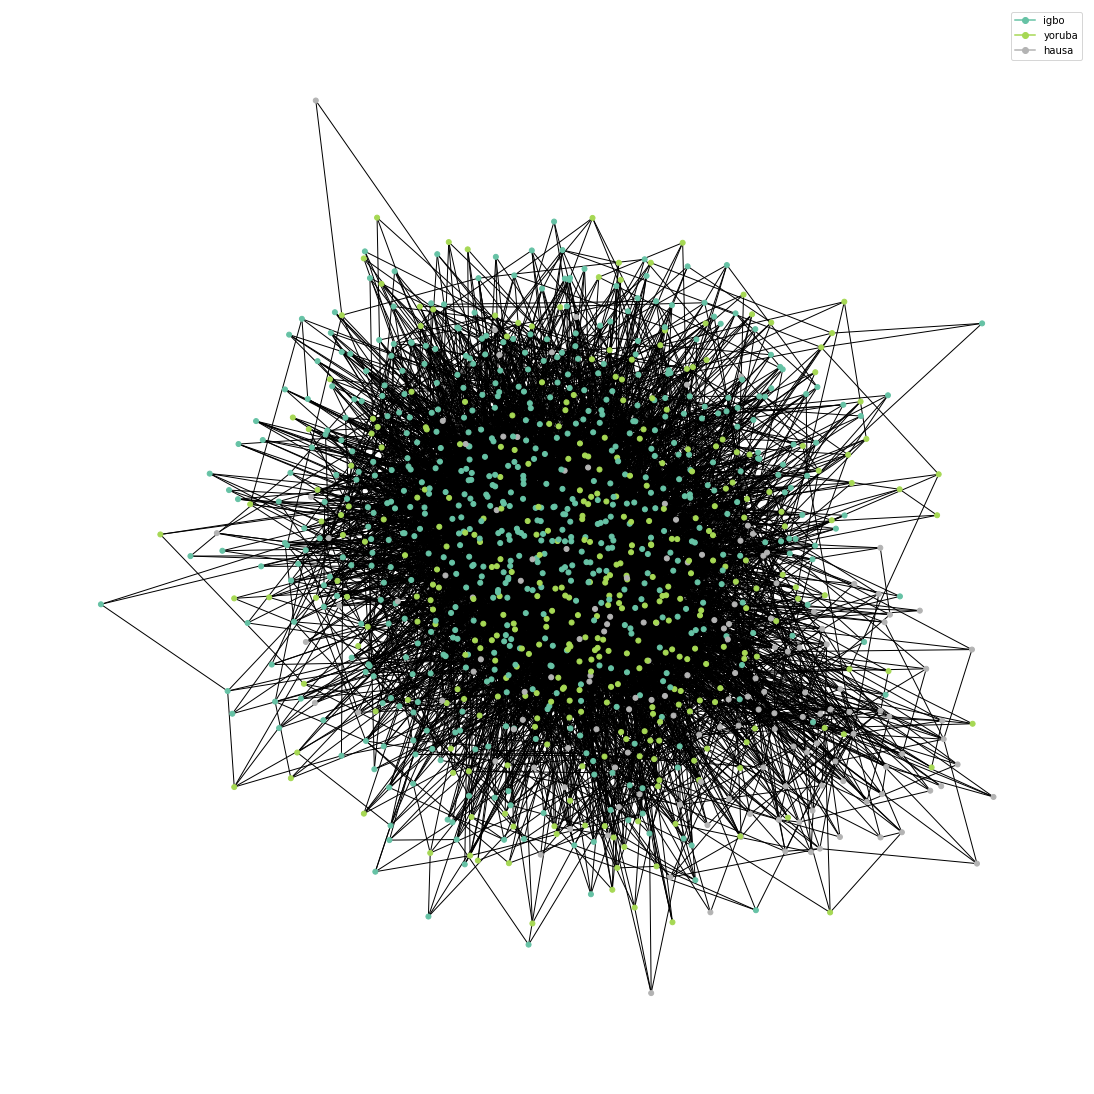

In [16]:
# G_subset = get_connected_subset(G, 1000, hateful_user_df_ethnicity_na_dropped.ethnicity.unique())
# draw_graph_spring(G_subset, cat_df, 'ethnicity')

G_random_subset = get_random_subset(G, 2000)
G_random_subset = remove_nodes_with_few_connections(G_random_subset, min_degree=4)
draw_graph_spring(G_random_subset, cat_df, 'ethnicity')

### Clustering by `n_tweets`

In [17]:
filtered_hateful_user_df['tweet_category'], bins = pd.qcut(filtered_hateful_user_df['n_tweets'], 3, labels=['low', 'medium', 'high'], retbins=True)

/var/folders/qt/1h9nv5kn2y9drlc5qr0zc_ph0000gp/T/ipykernel_7048/2068032086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_hateful_user_df['tweet_category'], bins = pd.qcut(filtered_hateful_user_df['n_tweets'], 3, labels=['low', 'medium', 'high'], retbins=True)


In [18]:
cat_df = filtered_hateful_user_df[['user_id', 'tweet_category']].set_index('user_id')
G = nx.from_pandas_edgelist(filtered_twitter_df, 'src', 'dst')

# Assign Categories as Node Attributes
for node in tqdm(G.nodes, desc='Assigning Categories'):
    # Fetch the category from cat_df; if node not in cat_df, default to None
    node_category = cat_df.loc[node, 'tweet_category'] if node in cat_df.index else None
    G.nodes[node]['tweet_category'] = node_category

Assigning Categories:   0%|          | 0/80154 [00:00<?, ?it/s]

In [19]:
G_subset = get_connected_subset_by_tweet_category(G, 2000)

Building Subset:   0%|          | 0/2000 [00:00<?, ?it/s]

In [21]:
G_random_subset = get_random_subset(G, )
draw_graph_spring(G_subset, cat_df, 'tweet_category')

KeyError: 1239628423565279239

In [24]:
1239628423565279239 in G_subset.nodes

True

### Cluster by ethnicity tweeted at

In [ ]:
ethnicity_cols = ['n_northerner_tweets', 'n_hausa_tweets', 'n_fulani_tweets',
                  'n_southerner_tweets', 'n_yoruba_tweets', 'n_biafra_tweets', 'n_igbo_tweets']

# Determine the primary ethnicity for each user
filtered_hateful_user_df['primary_ethnicity'] = filtered_hateful_user_df[ethnicity_cols].idxmax(axis=1)
filtered_hateful_user_df.primary_ethnicity.value_counts()

In [ ]:
cat_df = filtered_hateful_user_df[['user_id', 'primary_ethnicity']].set_index('user_id')
cat_df.head(2)

In [ ]:
# Create a graph from filtered_twitter_df
G = nx.from_pandas_edgelist(filtered_twitter_df, 'src', 'dst')

# Add ethnicity attributes to the nodes
for node in tqdm(G.nodes, desc='Adding Ethnicity Attributes'):
    G.nodes[node]['ethnicity'] = cat_df.loc[node, 'primary_ethnicity'] if node in cat_df.index else None

In [ ]:
G_subset = get_connected_subset_by_hate_tweet_ethnicity(G, 2000)

In [ ]:
missing = []
for node in set(G_subset.nodes):
    if node not in cat_df.index:
        missing.append(node)

len(missing)

### Clustering by ethnicity hate retweets

In [ ]:
# Columns representing different retweet ethnicities
retweet_cols = ['n_northerner_retweets', 'n_hausa_retweets', 'n_fulani_retweets',
                'n_southerner_retweets', 'n_yoruba_retweets', 'n_biafra_retweets', 'n_igbo_retweets']

# Drop users with zero retweets across all categories
filtered = filtered_hateful_user_df[retweet_cols].sum(axis=1) > 0
filtered_hateful_user_df = filtered_hateful_user_df[filtered]

# Determine the primary retweet category for each user
filtered_hateful_user_df['primary_retweet_category'] = filtered_hateful_user_df[retweet_cols].idxmax(axis=1)

In [ ]:
cat_df = filtered_hateful_user_df[['user_id', 'primary_retweet_category']].set_index('user_id')
cat_df.head(2)

In [ ]:
# Create a graph
G = nx.from_pandas_edgelist(filtered_twitter_df, 'src', 'dst')

# Add retweet category attributes to the nodes
for node in tqdm(G.nodes, desc='Adding Retweet Category Attributes'):
    G.nodes[node]['retweet_category'] = cat_df.loc[node, 'primary_retweet_category'] if node in cat_df.index else None

In [ ]:
G_subset = 